In [1]:
import sys
sys.path.append("../../../")

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import thread_map

from librep.datasets.har.generator import HARDatasetGenerator, DatasetSplitError

from typing import List, Tuple, Dict, Union, Optional
import random

%matplotlib inline

2022-11-10 14:51:57.417300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 14:51:57.417372: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

standard_activity_names =  {v: k for k, v in standard_activity_codes.items()}

## Loading files

In [4]:
es_dir = Path("../../../../data/datasets/ExtraSensory/raw")
label_dir = Path("../../../../data/datasets/ExtraSensory/labels")
es_files = sorted(list(es_dir.rglob("*.csv")))
es_files = {
    f.stem.split("_")[0]: {
        "data": f,
        "label": next(label_dir.glob(f"{f.stem.split('_')[0]}*"))
    }
    for f in es_files
}

print(list(es_files.items())[0])

('00EABED2-271D-49D8-B599-1D4A09240601', {'data': PosixPath('../../../../data/datasets/ExtraSensory/raw/00EABED2-271D-49D8-B599-1D4A09240601_raw.csv'), 'label': PosixPath('../../../../data/datasets/ExtraSensory/labels/00EABED2-271D-49D8-B599-1D4A09240601_labels.csv')})


In [5]:
def label_map(merged_label):
    if not isinstance(merged_label, str):
        return float('nan')
    if "SITTING" in merged_label:
        return standard_activity_names["sit"]
    elif "OR_standing" in merged_label:
        return standard_activity_names["stand"]
    elif "FIX_walking" in merged_label:
        return standard_activity_names["walk"]
    elif "FIX_running" in merged_label:
        return standard_activity_names["run"]
    else:
        return float('nan')

In [6]:
maintain = [
    'timestamp source', 'accelerometer timestamp', 'accelerometer-x',
    'accelerometer-y', 'accelerometer-z', 'gyroscope timestamp',
    'gyroscope-x', 'gyroscope-y', 'gyroscope-z', 'gravity timestamp',
    'gravity-x', 'gravity-y', 'gravity-z', 'merged label',
    'standard activity code'
]

output_dir = Path("../../../../data/datasets/ExtraSensory/raw_processed")

for user, values in tqdm.tqdm(es_files.items(), total=len(es_files), desc="Procesing files..."):
    data, label = pd.read_csv(values["data"]), pd.read_csv(values["label"])

    # Merge the dataframes
    merged_df = pd.merge(data, label, on="timestamp source")

    # Drop samples that does not match these conditions:
    # Is not a SITTING, nor stand, nor walk, not run
    # merged_df = merged_df.drop(merged_df[
    #     (merged_df["SITTING"] == False) &
    #     (merged_df["OR_standing"] == False) &
    #     (merged_df["FIX_walking"] == False) &
    #     (merged_df["FIX_running"] == False)].index)

    # Make standard label
    merged_df["standard activity code"] = merged_df["merged label"].apply(label_map)
    merged_df = merged_df[merged_df['standard activity code'].notna()]
    merged_df = merged_df[maintain]

    merged_df["standard activity code"] = merged_df["standard activity code"].astype(int)
    merged_df["user"] = user
    merged_df = merged_df.reset_index(drop=True)
    merged_df.to_csv(output_dir / f"{user}.csv", index=False)

Procesing files...: 100%|█████████████████████████████████████████████| 57/57 [34:03<00:00, 35.84s/it]


## Join merged dfs in a single dataframe

## Process

In [ ]:
from scipy import signal
import scipy
import itertools

h = signal.butter(3, 0.3, 'hp', fs=50, output='sos')

time = 800 / 40 # Number of samples (es default) / frequency (es default) = seconds (20)

for f in tqdm.tqdm(list(output_dir.glob("*.csv"))):
    df = pd.read_csv(f)
    
    # Check if it is in G or m/s**2
    for name, subdf in df.groupby("timestamp source"):
        subdf["norm"] = np.sqrt((subdf["accelerometer-x"])**2 + (subdf["accelerometer-y"])**2 + (subdf["accelerometer-z"])**2)
        if np.mean(subdf["norm"]) < 6:
            G_val = scipy.constants.g
        else:
            G_val = 1  # neutral multiplication element
        
    dfs = []
    for i, (name, subdf) in enumerate(df.groupby("timestamp source")):
        new_df = pd.DataFrame()
        for sensor, axis in itertools.product(["accelerometer", "gyroscope"], ["x","y","z"]):
            column = f"{sensor}-{axis}"
            values = (df[column] * G_val).values
            values = signal.sosfiltfilt(h, values)
            values = signal.resample(values, int(time*20))
            new_df[column] = values
        new_df["timestamp source"] = name
        new_df["merged label"] = subdf["merged label"].values[0]
        new_df["standard activity code"] = subdf["standard activity code"].values[0]
        new_df["user"] = subdf["user"].values[0]
        dfs.append(new_df)

    df = pd.concat(dfs).reset_index(drop=True)
    df.to_csv(f, index=False)

  0%|                                                                                      | 0/57 [00:00<?, ?it/s]

In [113]:
df

,Unnamed: 0,timestamp source,accelerometer timestamp,accelerometer-x,accelerometer-y,accelerometer-z,gyroscope timestamp,gyroscope-x,gyroscope-y,gyroscope-z,gravity timestamp,gravity-x,gravity-y,gravity-z,merged label,standard activity code,user
0,0,1441314267,412821.030,0.581726,0.306107,9.660019,412821.100,0.065582,0.190674,0.019821,412821.100,0.065582,0.190674,0.019821,SITTING,0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
1,1,1441314267,412821.030,0.625000,0.306107,9.679260,412821.100,0.007904,-0.017609,-0.002609,412821.100,0.007904,-0.017609,-0.002609,SITTING,0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
2,2,1441314267,412821.060,0.573517,0.306107,9.642181,412821.120,0.010040,0.002686,0.000595,412821.120,0.010040,0.002686,0.000595,SITTING,0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
3,3,1441314267,412821.100,0.610733,0.306107,9.636200,412821.160,0.014313,0.005890,0.000595,412821.160,0.014313,0.005890,0.000595,SITTING,0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
4,4,1441314267,412821.100,0.689697,0.310532,9.650925,412821.200,0.005768,-0.000519,-0.001541,412821.200,0.005768,-0.000519,-0.001541,SITTING,0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267195,2267195,1441925785,44657.050,-3.179245,-0.670960,9.002930,44661.105,-0.000259,0.001022,0.000839,44661.105,-0.000259,0.001022,0.000839,"COMPUTER_WORK, LOC_main_workplace, PHONE_IN_PO...",0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
2267196,2267196,1441925785,44657.070,-3.180283,-0.670960,9.003967,44661.130,0.002945,-0.000046,-0.001297,44661.130,0.002945,-0.000046,-0.001297,"COMPUTER_WORK, LOC_main_workplace, PHONE_IN_PO...",0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
2267197,2267197,1441925785,44657.094,-3.190308,-0.670960,9.003967,44661.156,0.002945,-0.001114,0.000839,44661.156,0.002945,-0.001114,0.000839,"COMPUTER_WORK, LOC_main_workplace, PHONE_IN_PO...",0,33A85C34-CFE4-4732-9E73-0A7AC861B27A
2267198,2267198,1441925785,44657.113,-3.199432,-0.655731,8.988739,44661.180,0.000809,-0.000046,-0.002365,44661.180,0.000809,-0.000046,-0.002365,"COMPUTER_WORK, LOC_main_workplace, PHONE_IN_PO...",0,33A85C34-CFE4-4732-9E73-0A7AC861B27A


In [106]:
np.mean(df["sum"]) < 6

True

<AxesSubplot:>

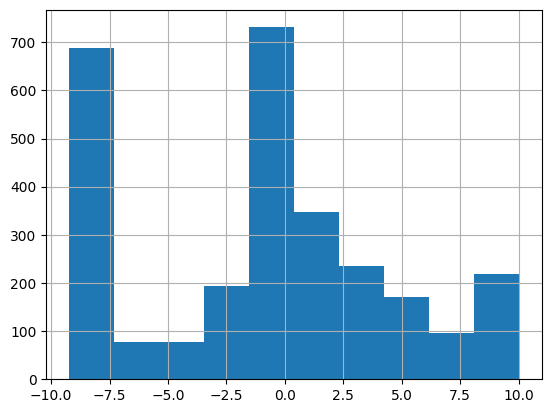

In [72]:
pd.DataFrame(values)["y mean"].hist()

<AxesSubplot:>

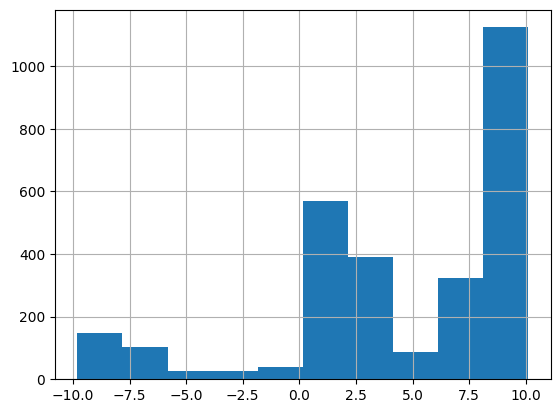

In [73]:
pd.DataFrame(values)["z mean"].hist()